## SHAP on R2B5 NARVAL data

### How many samples do we need to approximate the expected value well?
Conclusion: We need at least 10000 samples.

In [3]:
import os
import sys
import gc
import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import shap

from tensorflow.keras.models import load_model
from tensorflow import nn 
import tensorflow as tf

# Add path with my_classes to sys.path
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/')

import importlib
import my_classes
importlib.reload(my_classes)

from my_classes import load_data
from my_classes import read_mean_and_std

In [2]:
# # Won't run on a CPU node
# try:
#     # Prevents crashes of the code
#     physical_devices = tf.config.list_physical_devices('GPU')
#     tf.config.set_visible_devices(physical_devices[0], 'GPU')
#     # Allow the growth of memory Tensorflow allocates (limits memory usage overall)
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
# except:
#     pass

In [3]:
root_path = '/pf/b/b309170'
# data_path = os.path.join(root_path,
#                          'my_work/NARVAL/data_var_vertinterp_R02B05')
model_path = os.path.join(root_path,
                          'workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/saved_models')

#### Load the model

In [4]:
os.listdir(model_path+'/cloud_cover_R2B5_QUBICC')

['cross_validation_column_based_fold_3.txt',
 '.ipynb_checkpoints',
 'cross_validation_column_based_fold_3.h5',
 'cross_validation_column_based_fold_2.txt',
 'cross_validation_column_based_fold_2.yaml',
 'cross_validation_column_based_fold_2.h5',
 'cross_validation_column_based_fold_1.txt',
 'cross_validation_column_based_fold_3.yaml',
 'scaler_100.txt',
 'cross_validation_column_based_fold_1.h5',
 'cross_validation_column_based_fold_1.yaml']

In [5]:
# custom_objects = {}
# custom_objects['leaky_relu'] = nn.leaky_relu

fold_1 = 'cross_validation_column_based_fold_1.h5'

model_fold_1 = load_model(os.path.join(model_path+'/cloud_cover_R2B5_QUBICC', fold_1))

#### Setting up SHAP

In [6]:
remove_fields = [27, 28, 29, 30, 31, 32, 135, 136, 137]
# Load column-based R2B5 training data
path_train_data = '/pf/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/based_on_var_interpolated_data'
input_train = np.transpose(np.load(path_train_data + '/cloud_cover_input_qubicc.npy'))
input_train = np.delete(input_train, remove_fields, axis=1)

In [7]:
mean_1, std_1 = read_mean_and_std(model_path+'/cloud_cover_R2B5_QUBICC/cross_validation_column_based_fold_1.txt')

In [ ]:
for no_samples_train in [10**6, 5000000]:

    rand_indices_train = np.random.randint(0, input_train.shape[0], no_samples_train)

    # Load column-based R2B5 training data
    input_train_rand = np.float32(input_train)[rand_indices_train]
    input_train_rand = (input_train_rand-mean_1)/std_1

    t0 = time.time()
    #initialize js methods for visualization
    shap.initjs()

    # It takes any combination of a model and masker (usually the training data!) and 
    # returns a callable subclass object that implements the particular estimation algorithm 
    # (e.g. 'kernel' or 'deep') that was chosen.
    # Data is taken to compute the base value.
    explainer_shap = shap.KernelExplainer(model=model_fold_1, data=input_train_rand) 

    print(no_samples_train)
    print(time.time() - t0)
    print(explainer_shap.expected_value)
    
    with open('expectation_per_amount_of_samples.txt', 'a') as file:
        file.write(str(no_samples_train)+'\n')
        file.write(str(time.time() - t0)+'\n')
        file.write(str(explainer_shap.expected_value)+'\n\n')

In [5]:
# How many samples do we need to robustly infer the expected value?
E1 = [-6.70066927e-03,5.48779514e-03,5.31691701e-02,1.73263384e+00
,8.26189680e+00,1.78890971e+01,2.02633631e+01,1.88770963e+01
,2.02855351e+01,2.18268311e+01,2.01937389e+01,1.58798361e+01
,1.25059776e+01,9.35228180e+00,8.50248286e+00,6.92911374e+00
,6.40444001e+00,8.19088908e+00,7.85823876e+00,7.04453152e+00
,6.73058294e+00,7.44807479e+00,7.19609977e+00,4.57910603e+00
,3.34694732e+00,4.34899836e+00,6.37688739e+00] # E_100
E2 = [-7.96983839e-03,4.80805124e-04,-4.47983691e-02,7.26756270e-01
,6.11145171e+00,1.20233314e+01,1.40091897e+01,1.50375263e+01
,1.67760922e+01,1.73312869e+01,1.72076474e+01,1.45300381e+01
,1.22620570e+01,1.11234621e+01,1.16446906e+01,1.07375788e+01
,1.18131114e+01,1.13529007e+01,1.17944485e+01,1.38045435e+01
,1.40982311e+01,1.38675235e+01,1.14881254e+01,8.80543791e+00
,7.81629629e+00,7.24866641e+00,7.08663715e+00] # E_200
E3 = [-4.86992798e-03,1.43115679e-03,6.22835729e-02,1.66514260e+00
,9.59536869e+00,1.60296906e+01,1.70178907e+01,1.65836501e+01
,1.72734143e+01,1.91784277e+01,1.83380204e+01,1.48003833e+01
,1.19120091e+01,9.72493117e+00,7.81195687e+00,6.59793149e+00
,6.82537627e+00,7.09331944e+00,7.92958404e+00,9.04130222e+00
,1.04818458e+01,1.07409894e+01,8.46654289e+00,5.85082590e+00
,5.50540421e+00,5.63191483e+00,6.46622323e+00] # E_500
E4 = [-4.92475658e-03,-1.97106724e-03,-1.74757975e-02,1.17609006e+00
,7.81096191e+00,1.43909348e+01,1.61677860e+01,1.50273148e+01
,1.59014772e+01,1.69887509e+01,1.64934768e+01,1.30415528e+01
,1.06480629e+01,9.23762214e+00,7.51287595e+00,7.45114403e+00
,7.27528076e+00,7.20805536e+00,8.18046644e+00,9.86160220e+00
,1.09822412e+01,1.09839236e+01,8.83855272e+00,6.41129637e+00
,5.59432267e+00,5.59550850e+00,6.80167090e+00] # E_1000
E5 = [-5.44012342e-03,-1.20179941e-04,-8.59753148e-03,1.07414187e+00
,7.12579908e+00,1.36356139e+01,1.55943260e+01,1.55466515e+01
,1.64678945e+01,1.78294740e+01,1.73404792e+01,1.44502191e+01
,1.17417161e+01,9.91878935e+00,8.34327271e+00,8.08819498e+00
,7.87552419e+00,8.05749956e+00,9.04465972e+00,1.06490980e+01
,1.23000215e+01,1.21218363e+01,9.44825154e+00,6.77887089e+00
,5.76103134e+00,5.31868626e+00,6.32904016e+00] # E_5000
E6 = [-5.17830591e-03,1.90582416e-04,-9.23705863e-03,1.05847578e+00
,7.02553155e+00,1.33878502e+01,1.53854405e+01,1.51045870e+01
,1.59627583e+01,1.71965229e+01,1.64804505e+01,1.32987426e+01
,1.07381136e+01,9.32747877e+00,8.02133501e+00,7.66608411e+00
,7.41292899e+00,7.83569079e+00,8.80585705e+00,1.05535987e+01
,1.23739637e+01,1.20100155e+01,9.19590681e+00,6.77433367e+00
,6.05899679e+00,5.64241257e+00,6.36318937e+00] # E_10000
E7 = [-5.50625412e-03,-1.94744581e-04,-1.02830998e-02,9.75953315e-01
,6.80999678e+00,1.32295026e+01,1.51323753e+01,1.49329481e+01
,1.58721812e+01,1.72173116e+01,1.66736592e+01,1.36941876e+01
,1.12925865e+01,9.75425025e+00,8.31664882e+00,7.85457885e+00
,7.54275051e+00,7.96040923e+00,8.86734026e+00,1.05051555e+01
,1.21325451e+01,1.19634746e+01,9.00261683e+00,6.43186304e+00
,5.67198297e+00,5.42455291e+00,6.42646872e+00] # E_100000
E8 = [-5.57057974e-03,-1.18107170e-04,-1.04520819e-02,9.90513555e-01
,6.90104161e+00,1.33547206e+01,1.52789591e+01,1.50691905e+01
,1.60346382e+01,1.73512803e+01,1.67468250e+01,1.36874030e+01
,1.12444305e+01,9.73615896e+00,8.33504130e+00,7.85691095e+00
,7.56800806e+00,8.01385526e+00,8.91638823e+00,1.05617828e+01
,1.21740895e+01,1.20507614e+01,9.09691075e+00,6.51572672e+00
,5.74196661e+00,5.41552543e+00,6.37490017e+00] # E_100000

In [2]:
out_array = np.zeros(7)
out_array[0] = np.max(np.abs(np.array(E2) - np.array(E1)))
out_array[1] = np.max(np.abs(np.array(E3) - np.array(E2)))
out_array[2] = np.max(np.abs(np.array(E4) - np.array(E3)))
out_array[3] = np.max(np.abs(np.array(E5) - np.array(E4)))
out_array[4] = np.max(np.abs(np.array(E6) - np.array(E5)))
out_array[5] = np.max(np.abs(np.array(E7) - np.array(E6)))
out_array[6] = np.max(np.abs(np.array(E8) - np.array(E7)))

a = np.arange(1, 8)

NameError: name 'np' is not defined

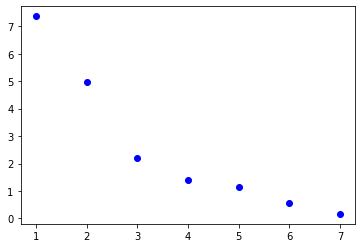

In [31]:
# Absolute error
plt.plot(a, out_array, 'bo')

In [6]:
out_array = np.zeros(7)
out_array[0] = np.max(np.abs(np.array(E2) - np.array(E1))/np.abs(np.array(E8)))
out_array[1] = np.max(np.abs(np.array(E3) - np.array(E2))/np.abs(np.array(E8)))
out_array[2] = np.max(np.abs(np.array(E4) - np.array(E3))/np.abs(np.array(E8)))
out_array[3] = np.max(np.abs(np.array(E5) - np.array(E4))/np.abs(np.array(E8)))
out_array[4] = np.max(np.abs(np.array(E6) - np.array(E5))/np.abs(np.array(E8)))
out_array[5] = np.max(np.abs(np.array(E7) - np.array(E6))/np.abs(np.array(E8)))
out_array[6] = np.max(np.abs(np.array(E8) - np.array(E7))/np.abs(np.array(E8)))

a = np.arange(1, 8)

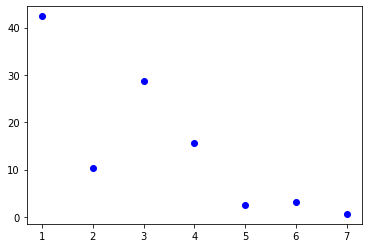

In [38]:
# Relative error
plt.plot(a, out_array, 'bo')

In [7]:
out_array

array([42.39361604, 10.24503472, 28.80624462, 15.67125263,  2.6311896 ,
        3.26251994,  0.64888026])

In [10]:
np.max((np.abs(np.array(E6) - np.array(E5))/np.abs(np.array(E8)))[2:])

0.08925329744356546

In [11]:
# Relative error discarding two upper-most two layers

out_array = np.zeros(7)
out_array[0] = np.max((np.abs(np.array(E2) - np.array(E1))/np.abs(np.array(E8)))[2:])
out_array[1] = np.max((np.abs(np.array(E3) - np.array(E2))/np.abs(np.array(E8)))[2:])
out_array[2] = np.max((np.abs(np.array(E4) - np.array(E3))/np.abs(np.array(E8)))[2:])
out_array[3] = np.max((np.abs(np.array(E5) - np.array(E4))/np.abs(np.array(E8)))[2:])
out_array[4] = np.max((np.abs(np.array(E6) - np.array(E5))/np.abs(np.array(E8)))[2:])
out_array[5] = np.max((np.abs(np.array(E7) - np.array(E6))/np.abs(np.array(E8)))[2:])
out_array[6] = np.max((np.abs(np.array(E8) - np.array(E7))/np.abs(np.array(E8)))[2:])

a = np.arange(1, 8)

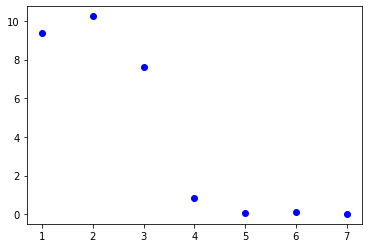

In [12]:
# Relative error
plt.plot(a, out_array, 'bo')

In [13]:
out_array

array([ 9.3730168 , 10.24503472,  7.63095536,  0.84942561,  0.0892533 ,
        0.1000797 ,  0.01616731])